# Análisis de Grandes Volúmenes de Datos
### Actividad 4 | Métricas de calidad de resultados

Estudiante:

+ Eduardo Selim Martínez Mayorga - A01795167

In [1]:
#Descargamos las librerias necesarias, iniciamos sesion de Pyspark y cargamos la base de datos
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import countDistinct, count, isnan, when, desc, concat_ws, monotonically_increasing_id
from pyspark.sql.functions import col, expr, mean, stddev, min, max, length, ceil, floor
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, NumericType
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("CSVRead").getOrCreate()
df = spark.read.csv("Iowa_Liquor_Sales.csv", header=True, inferSchema=True)

25/06/08 13:55:09 WARN Utils: Your hostname, MacBook-Air-de-Eduardo.local resolves to a loopback address: 127.0.0.1; using 10.200.100.163 instead (on interface en0)
25/06/08 13:55:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/08 13:55:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/08 13:55:26 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [3]:
# Cambiamos los nombres de las columnas para facilitar su manejo al programar
df = df.withColumnsRenamed({"Invoice/Item Number": "invoice_number",
"Date": "date",
"Store Number": "store_number",
"Store Name": "store_name",
"Address": "address",
"City": "city",
"Zip Code": "zip_code",
"Store Location": "store_location",
"County Number": "county_number",
"County": "county",
"Category": "category",
"Category Name": "category_name",
"Vendor Number": "vendor_number",
"Vendor Name": "vendor_name",
"Item Number": "item_number",
"Item Description": "item_description",
"Pack": "pack",
"Bottle Volume (ml)": "bottle_volume",
"State Bottle Cost": "bottle_cost",
"State Bottle Retail": "bottle_retail",
"Bottles Sold": "bottles_sold",
"Sale (Dollars)": "sale_dollars",
"Volume Sold (Liters)": "liters_sold",
"Volume Sold (Gallons)": "gallons_sold"})

## Parte 1: Selección de los datos

En esta parte se utilizará una variación de la rutina de la actividad pasada para construir un subconjunto de trabajo del 0.5% del dataset original (2 millones de datos aproximadamente) utilizando el criterio de estratificación basado en la categoría del producto (`category`) y el vendedor del producto (`vendor_number`).

In [4]:
# Variables de caracterización
vars_caracterizacion = ["category","vendor_number"]

# Total de filas para calcular proporciones
total = df.count()

# Agrupar por combinaciones y contar ocurrencias
df_grouped = df.groupBy(vars_caracterizacion).agg(count("*").alias("conteo"))

# Calcular probabilidad de cada combinación
df_prob = df_grouped.withColumn("probabilidad", col("conteo") / total)

# Conteo nos dice cuantas veces se repite una combinacion
# Probabilidad indica la probabilidad que hay de que salga dicha combinación
# Mostrar ejemplo de combinaciones y sus probabilidades
df_prob = df_prob.orderBy(desc("probabilidad"))

# Creamos la etiqueta del estrato concatenando el número de categoría y el número de vendedor con un guion de por medio
df_estrato = df_prob.select(concat_ws('_',df_prob.category,df_prob.vendor_number).alias("estrato"),
                            "category", "vendor_number", "conteo", "probabilidad")

# Creamos la etiqueta del estrato en el dataset completo
# concatenando el número de categoría y el número de vendedor con un guion de por medio
df = df.withColumn("estrato", concat_ws('_',df.category,df.vendor_number))

# Se define la proporción de la población que se requiere muestrear
prop_poblacion = 0.005

# Se obtiene el tamaño total de la muestra
n = math.ceil(total*prop_poblacion)

# Se obtiene una columna con el tamaño de muestra requerido de cada estrato
df_estrato = df_estrato.withColumn("muestra", col("probabilidad") * n)
df_estrato = df_estrato.withColumn("tamanio_muestra", ceil("muestra"))
df_estrato = df_estrato.withColumn("proporcion_estrato", col("tamanio_muestra")/col("conteo"))

# Se convierte el spark DataFrame en Pandas dataframe para extraer la proporción por estratos a muestrear
pandas_estratos = df_estrato.toPandas()

# Se construye un diccionario con la proporción a muestrear requerida en cada estrato
proporciones = pandas_estratos.set_index('estrato')['proporcion_estrato'].to_dict()

# RESULTADO FINAL
# Se obtiene la muestra por cada estrato del tamaño adecuado
muestra_df = df.sampleBy(col = "estrato", fractions = proporciones, seed = 5)

# Se obtiene el tamaño total del dataset
n_dataset = muestra_df.count()

Después del proceso de muestreo estratificado, el número de observaciones en el dataset de trabajo es

In [5]:
n_dataset

132264

A continuación se muestra un breve extracto del dataset de trabajo para esta actividad

In [6]:
muestra_df.show(3)

+--------------+----------+------------+--------------------+---------------+----------+--------+--------------------+-------------+---------+--------+-----------------+-------------+---------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+
|invoice_number|      date|store_number|          store_name|        address|      city|zip_code|      store_location|county_number|   county|category|    category_name|vendor_number|    vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato|
+--------------+----------+------------+--------------------+---------------+----------+--------+--------------------+-------------+---------+--------+-----------------+-------------+---------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+---

In [7]:
# Le generamos un id a cada observación (renglón)
muestra_df = muestra_df.withColumn('id', monotonically_increasing_id())

Adicionalmente, se seleccionará como variable objetivo para aprendizaje supervisado al precio del producto (`sale_dolars`) y como variables explicativas al volumen de la botella (`bottle_volumen`), el costo de la botella (`bottle_cost`), el número de botellas vendidas (`bottles_sold`), litros vendidos (`liters_sold`) como numéricas y a la categoría del producto (`category`) y tipo de empaque (`pack`) como categóricas

In [8]:
variable_objetivo = "sale_dollars"
explicativas_numericas = ["bottle_volume", "bottle_cost", "bottles_sold", "liters_sold"]
explicativas_categoricas = ["category", "pack"]

## Parte 2: Preparación de los datos

En esta sección se completarán valores faltantes, tanto para variables numéricas como para categóricas. Además, las variables categóricas se codificación (one-hot-encoding) para que se pueden utilizar en el modelo de aprendizaje supervisado. También, se escalarán/estandarizarán/normalizará las variables numéricas para tener estabilidad en los algoritmos tanto de aprendizaje supervisado como en los de no supervisado.

In [9]:
# Corrección de datos faltantes para variables categóricas
## Se calcula la moda para las varaibles categóricas
mode_category1 = muestra_df.groupBy("category").agg(count("*").alias("count")).orderBy(col("count").desc()).first()["category"]
mode_category2 = muestra_df.groupBy("pack").agg(count("*").alias("count")).orderBy(col("count").desc()).first()["pack"]

## Se completan los datos faltantes de las variables categóricas con las modas
muestra_df = muestra_df.withColumn("category", when(col("category").isNull(), mode_category1).otherwise(col("category")))
muestra_df = muestra_df.withColumn("pack", when(col("pack").isNull(), mode_category2).otherwise(col("pack")))

muestra_df.show(2)

25/06/08 14:01:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+----------+------------+--------------------+-------------+----------+--------+--------------------+-------------+---------+--------+-----------------+-------------+---------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+---+
|invoice_number|      date|store_number|          store_name|      address|      city|zip_code|      store_location|county_number|   county|category|    category_name|vendor_number|    vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato| id|
+--------------+----------+------------+--------------------+-------------+----------+--------+--------------------+-------------+---------+--------+-----------------+-------------+---------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+-

In [10]:
# Se completan los datos numéricos faltantes
imputer = Imputer(inputCols = explicativas_numericas,
                  outputCols = explicativas_numericas)

imputer = imputer.fit(muestra_df)

muestra_df = imputer.transform(muestra_df)

In [11]:
# Generamos el objeto con las variables explicativas numéricas
vector_assembler_numerico = VectorAssembler(inputCols = explicativas_numericas,
                                            outputCol = 'explicativas_numericas_vector')

muestra_df = vector_assembler_numerico.transform(muestra_df)

In [12]:
# A las varibles categóricas primero las representaremos mediante un índice único y posteriormente se le aplicará one-hot encoding

## Se representa a las categorías de las variables categóricas como índices únicos
indexers = [
    StringIndexer(inputCol = c, outputCol = "{0}_index".format(c))
    for c in explicativas_categoricas
]

## Se aplica one-hot encoding a cada una de las variables categóricas
encoders = [
    OneHotEncoder(
        inputCol = indexer.getOutputCol(),
        outputCol = "{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

## Generamos el objeto con las variables explicativas categóricas
assembler = VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders],
    outputCol = "explicativas_categoricas_vector"
)

pipeline = Pipeline(stages = indexers + encoders + [assembler])
pipeline = pipeline.fit(muestra_df)

muestra_df = pipeline.transform(muestra_df)

muestra_df.show(2)

+--------------+----------+------------+--------------------+-------------+----------+--------+--------------------+-------------+---------+--------+-----------------+-------------+---------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+---+-----------------------------+--------------+----------+----------------------+------------------+-------------------------------+
|invoice_number|      date|store_number|          store_name|      address|      city|zip_code|      store_location|county_number|   county|category|    category_name|vendor_number|    vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato| id|explicativas_numericas_vector|category_index|pack_index|category_index_encoded|pack_index_encoded|explicativas_categoricas_vector|
+--------------+----------+------------+--------------

## Parte 3. Preparación del conjunto de entrenamiento y prueba

Se aplicará la misma lógica de muestreo estratificado para hacer la construcción de los conjuntos de entrenamiento (`train`) y de prueba (`test`) del 70% y 30%, respectivamente.

In [13]:
## Para crear la muestra de entrenamiento y prueba

## Se definen las proporciones para el muestreo estratificado
df_conteo_train = muestra_df.groupBy("estrato").agg(count("*").alias("conteo"))
df_estrato_train = df_estrato.select("estrato", "probabilidad")
df_estrato_train = df_estrato_train.join(df_conteo_train, ['estrato'], "inner")

## Se especifica el tamaño del conjunto de entrenamiento (70%)
n_train = math.ceil(0.7 * n_dataset)

## Se obtiene una columna con el tamaño de muestra requerido de cada estrato en la muestra de entrenamiento
df_estrato_train = df_estrato_train.withColumn("muestra_train", col("probabilidad") * n_train)
df_estrato_train = df_estrato_train.withColumn("tamanio_muestra_train", floor("muestra_train"))
df_estrato_train = df_estrato_train.withColumn("prop_estrato_train", col("tamanio_muestra_train")/col("conteo"))

# Se convierte el spark DataFrame en Pandas dataframe para extraer la proporción por estratos a muestrear
pandas_estratos_train = df_estrato_train.toPandas()
pandas_estratos_train["prop_estrato_train"] = pandas_estratos_train["prop_estrato_train"].clip(upper=1.)

# Se construye un diccionario con la proporción a muestrear requerida en cada estrato en la muestra de entrenamiento
proporciones_train = pandas_estratos_train.set_index('estrato')['prop_estrato_train'].to_dict()

# Se obtiene el conjunto de entrenamiento con el tamaño para cada estrato del tamaño adecuado
train = muestra_df.sampleBy(col = "estrato", fractions = proporciones_train, seed = 5)
num_train = train.count()

# Se obtiene el conjunto de prueba como todo lo que está en el dataset de trabajo pero NO en el conjunto de entrenamiento
test = muestra_df.join(train, ['id'], "leftanti")
num_test = test.count()

El tamaño de los dataset de trabajo, entrenamiento y prueba, respectivamente son:

In [14]:
print(n_dataset)
print(num_train)
print(num_test)

132264
91679
40585


In [15]:
# Se muestra un extracto del dataset de prueba
test.show(3)

+----+--------------+----------+------------+--------------------+-----------------+----------+--------+--------------------+-------------+---------+--------+------------------+-------------+--------------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+-----------------------------+--------------+----------+----------------------+------------------+-------------------------------+
|  id|invoice_number|      date|store_number|          store_name|          address|      city|zip_code|      store_location|county_number|   county|category|     category_name|vendor_number|         vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato|explicativas_numericas_vector|category_index|pack_index|category_index_encoded|pack_index_encoded|explicativas_categoricas_vector|
+----+--------------+----------+

In [16]:
# Se muestra un extracto del dataset de entrenamiento
train.show(3)

+--------------+----------+------------+--------------------+-------------------+-----------+--------+--------------------+-------------+----------+--------+-----------------+-------------+--------------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+---+-----------------------------+--------------+----------+----------------------+------------------+-------------------------------+
|invoice_number|      date|store_number|          store_name|            address|       city|zip_code|      store_location|county_number|    county|category|    category_name|vendor_number|         vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato| id|explicativas_numericas_vector|category_index|pack_index|category_index_encoded|pack_index_encoded|explicativas_categoricas_vector|
+--------------+----------+-

In [17]:
# Estandarizamos las variables numéricas para quitar el efecto de la escala de las variables originales
scaler = StandardScaler(inputCol = 'explicativas_numericas_vector',
                        outputCol= 'explicativas_numericas_vector_escaladas',
                        withStd=True, withMean=True)

scaler = scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

# Juntamos las variables explicativas categóricas como las varables explicativas numéricas
assembler = VectorAssembler(inputCols = ['explicativas_numericas_vector_escaladas', 'explicativas_categoricas_vector'],
                            outputCol = 'explicativas_final_vector')

train = assembler.transform(train)
test = assembler.transform(test)

In [18]:
# Se muestra un extracto del dataset de entrenamiento
train.show(2)

+--------------+----------+------------+--------------------+-------------+----------+--------+--------------------+-------------+---------+--------+-----------------+-------------+---------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+---+-----------------------------+--------------+----------+----------------------+------------------+-------------------------------+---------------------------------------+-------------------------+
|invoice_number|      date|store_number|          store_name|      address|      city|zip_code|      store_location|county_number|   county|category|    category_name|vendor_number|    vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato| id|explicativas_numericas_vector|category_index|pack_index|category_index_encoded|pack_index_encoded|explicativas_categori

## Parte 5. Construcción de modelos de aprendizaje supervisado y no supervisado
### Aprendizaje supervisado - Random forest

En esta actividad, el algoritmo de aprendizaje supervisado que se utilizará es un random forest

In [19]:
# Se define el objeto modelo random forest para variable objetivo numérica (i.e. un problema de regresión)
random_forest_reg = RandomForestRegressor(featuresCol = 'explicativas_final_vector', labelCol = variable_objetivo)

# Se ajusta el modelo a partir de los datos de entrenamiento
modelo = random_forest_reg.fit(train)

# Se obtienen las estimaciones a partir de modelo tanto en los datasets de entrenamiento como de prueba
pred_train = modelo.transform(train)
pred_test = modelo.transform(test)

In [20]:
# Se muestra un extracto del dataset con las predicciones en el dataset de prueba
pred_test.show(3)

+----+--------------+----------+------------+--------------------+-----------------+----------+--------+--------------------+-------------+---------+--------+------------------+-------------+--------------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+-----------------------------+--------------+----------+----------------------+------------------+-------------------------------+---------------------------------------+-------------------------+-----------------+
|  id|invoice_number|      date|store_number|          store_name|          address|      city|zip_code|      store_location|county_number|   county|category|     category_name|vendor_number|         vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato|explicativas_numericas_vector|category_index|pack_index|category_index_encoded|

# Parte 6: Métricas de calidad en aprendizaje supervisado

Las métricas de calidad son muy importanres para evaluar el rendimiento de algoritmos de aprendizaje supervisado. La elección de la métrica apropiada depende del tipo de problema y de los objetivos específicos del proyecto.

## Métricas para Problemas de Clasificación

+ **Exactitud (Accuracy):** La métrica más básica, se calcula como el porcentaje de predicciones correctas sobre el total. Es útil cuando las clases están balanceadas, pero puede ser engañosa con datasets desbalanceados.

+ **Precisión (Precision):** Mide la proporción de verdaderos positivos entre todas las predicciones positivas. Es particularmente importante cuando el costo de falsos positivos es alto, como en diagnósticos médicos o detección de spam.

+ **Sensibilidad/Recall:** Indica la proporción de verdaderos positivos identificados correctamente del total de casos positivos reales. Es importante cuando no podemos permitirnos perder casos positivos, como en detección de fraudes o enfermedades graves.

+ **F1-Score:** Combina precisión y recall en una sola métrica mediante su media armónica. Es especialmente útil cuando se necesita balancear ambos aspectos y cuando las clases están desbalanceadas.

+ **Especificidad:** Mide la habilidad del modelo para identificar correctamente los casos negativos. Es importante en aplicaciones donde los falsos positivos tienen consecuencias significativas.

+ **Área bajo la curva ROC (AUC-ROC):** Evalúa la habilidad del modelo para distinguir entre clases a través de diferentes umbrales. Un AUC de 0.5 indica rendimiento aleatorio (básicamente el lanzamiento de una moneda), mientras que 1.0 representa clasificación perfecta.

+ **Matriz de Confusión:** Proporciona una vista detallada de todos los tipos de errores de clasificación, permitiendo identificar patrones específicos de confusión entre clases.

## Métricas para Problemas de Regresión

+ **Error Cuadrático Medio (MSE):** Penaliza fuertemente los errores grandes debido al término cuadrático. Es útil cuando queremos evitar predicciones muy alejadas del valor real. $$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

+ **Raíz del Error Cuadrático Medio (RMSE):** :Mantiene las mismas unidades que la variable objetivo, facilitando la interpretación. Es sensible a valores atípicos.

+ **Error Absoluto Medio (MAE):** Es menos sensible a outliers que MSE, proporciona una medida directa del error promedio en las mismas unidades que la variable objetivo. $$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

+ **Coeficiente de Determinación ($R^2$):** Indica qué proporción de la varianza en la variable dependiente es explicada por el modelo. Valores cercanos a 1 indican mejor ajuste.

+ **Error Porcentual Absoluto Medio (MAPE):** Expresa el error como porcentaje, facilitando la comparación entre diferentes escalas de datos. $$MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100\%$$

Un mecanismo efectivo de evaluación requiere combinar varias métricas para obtener una visión más completa del rendimiento del modelo, considerando siempre el contexto específico del problema y las necesidades del usuario final.

En particular, el problema que se está analizando es de regresión. Por esta razón, se utilizarán como métricas a la **Raíz del Error Cuadrático Medio (RMSE)** y al **Error Absoluto Medio (MAE)**

In [21]:
# Se evaluará qué tan bueno es el modelo a partir de la raíz del error cuadrático medio (RMSE)
evaluator_rmse = RegressionEvaluator(labelCol = variable_objetivo, predictionCol = "prediction", metricName = "rmse")
rmse_train = evaluator_rmse.evaluate(pred_train)
rmse_test = evaluator_rmse.evaluate(pred_test)

# Se evaluará qué tan bueno es el modelo a partir del error absoluto medio medio (MAE)
evaluator_mae = RegressionEvaluator(labelCol = variable_objetivo, predictionCol = "prediction", metricName = "mae")
mae_train = evaluator_mae.evaluate(pred_train)
mae_test = evaluator_mae.evaluate(pred_test)

A continuación se muestran los RMSEs sobre los datos de entrenamiento y prueba, respectivamente

In [22]:
print(rmse_train)
print(rmse_test)

286.33139538605883
582.9067273009275


A continuación se muestran los MAEs sobre los datos de entrenamiento y prueba, respectivamente

In [23]:
print(mae_train)
print(mae_test)

54.20678215844433
69.30989100924789


## Elección de hiperparámetros

La optimización de hiperparámetros para `RandomForestRegressor` en MLlib de PySpark implica encontrar la combinación óptima de parámetros que proporcione el mejor rendimiento del modelo. Esto se logra utilizando la clase `CrossValidator` junto con un `ParamGridBuilder`.  

### Hiperparámetros clave a ajustar:  
+ **numTrees (n_estimators)**: El número de árboles de decisión en el bosque. Aumentar este valor puede mejorar la precisión, pero también incrementa el costo computacional.  
+ **maxDepth**: La profundidad máxima de cada árbol de decisión. Árboles más profundos pueden capturar patrones más complejos, pero corren el riesgo de sobreajuste (*overfitting*).  
+ **maxFeatures**: El número de características a considerar al buscar la mejor división en cada nodo. Puede ser un entero, un flotante (fracción de características) o estrategias específicas como `"auto"`, `"sqrt"` o `"log2"`.  
+ **minInstancesPerNode (min_samples_leaf)**: El número mínimo de instancias requeridas en un nodo hoja.  
+ **subsamplingRate (bootstrap)**: La fracción de datos de entrenamiento que se muestrea para construir cada árbol.

En mi caso particular, sólo consideraré el número de árboles en el bosque (`numTrees`) y la profundidad máxima de cada árbol de decisión (`maxDepth`). Podría inventarme una consideración técnica, pero en realidad es porque mi computadora local tarda mucho tiempo :(

In [36]:
rf = RandomForestRegressor(featuresCol = 'explicativas_final_vector', labelCol = variable_objetivo)

# Se define el grid de hiperparametros
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 30]).addGrid(rf.maxDepth, [5, 10]).build()

# Se define un cross-validator
cross_validator = CrossValidator(estimator = rf, estimatorParamMaps = paramGrid,
                                 evaluator = RegressionEvaluator(labelCol = variable_objetivo, predictionCol = "prediction",
                                                                 metricName = "rmse"),
                                 numFolds = 4, seed = 2025)

# Se entrena el modelo con los mejores hiperparámetros
cv_modelo_rf = cross_validator.fit(train)

25/06/08 15:39:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.5 KiB
25/06/08 15:39:16 WARN DAGScheduler: Broadcasting large task binary with size 1423.5 KiB
25/06/08 15:39:44 WARN DAGScheduler: Broadcasting large task binary with size 1100.9 KiB
25/06/08 15:39:47 WARN DAGScheduler: Broadcasting large task binary with size 1581.4 KiB
25/06/08 15:39:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/06/08 15:39:59 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/06/08 15:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1060.6 KiB
25/06/08 15:43:26 WARN DAGScheduler: Broadcasting large task binary with size 1433.3 KiB
25/06/08 15:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1077.1 KiB
25/06/08 15:43:55 WARN DAGScheduler: Broadcasting large task binary with size 1547.3 KiB
25/06/08 15:44:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/06/08 15:44:07 WARN DAGSche

In [37]:
# Se puede ver cual fue el mejor modelo
mejor_modelo_rf = cv_modelo_rf.bestModel

# Las importancias de cada variable del mejor modelo
importancias = mejor_modelo_rf.featureImportances

In [38]:
importancias

SparseVector(133, {0: 0.0344, 1: 0.2034, 2: 0.4412, 3: 0.1858, 4: 0.0051, 5: 0.0031, 6: 0.0036, 7: 0.0006, 8: 0.0014, 9: 0.0023, 10: 0.0002, 11: 0.0003, 12: 0.0002, 13: 0.0018, 14: 0.0041, 15: 0.0089, 16: 0.0, 17: 0.0005, 18: 0.0001, 19: 0.0041, 20: 0.0017, 21: 0.0011, 22: 0.0, 23: 0.0, 24: 0.0089, 25: 0.0003, 26: 0.0004, 27: 0.0002, 28: 0.0, 29: 0.0008, 30: 0.0003, 31: 0.0001, 32: 0.0001, 33: 0.0116, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0044, 38: 0.0027, 39: 0.0, 40: 0.0, 41: 0.0001, 42: 0.0, 43: 0.0, 44: 0.0001, 45: 0.001, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0006, 50: 0.0, 51: 0.0002, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 59: 0.0041, 62: 0.0, 63: 0.0, 64: 0.0006, 66: 0.0072, 67: 0.0, 68: 0.0, 69: 0.0, 71: 0.0, 73: 0.0, 81: 0.0, 87: 0.0, 91: 0.0, 114: 0.0123, 115: 0.0126, 116: 0.0012, 117: 0.0245, 118: 0.0, 119: 0.0001, 120: 0.0001, 121: 0.0, 122: 0.0, 123: 0.0001, 124: 0.0011, 126: 0.0, 131: 0.0})

In [39]:
# Se obtienen las estimaciones a partir del mejor modelo tanto en los datasets de entrenamiento como de prueba
pred_train = mejor_modelo_rf.transform(train)
pred_test = mejor_modelo_rf.transform(test)

# Se evaluará qué tan bueno es el modelo a partir de la raíz del error cuadrático medio (RMSE)
evaluator_rmse = RegressionEvaluator(labelCol = variable_objetivo, predictionCol = "prediction", metricName = "rmse")
rmse_train = evaluator_rmse.evaluate(pred_train)
rmse_test = evaluator_rmse.evaluate(pred_test)

# Se evaluará qué tan bueno es el modelo a partir del error absoluto medio medio (MAE)
evaluator_mae = RegressionEvaluator(labelCol = variable_objetivo, predictionCol = "prediction", metricName = "mae")
mae_train = evaluator_mae.evaluate(pred_train)
mae_test = evaluator_mae.evaluate(pred_test)

A continuación se muestran los RMSEs sobre los datos de entrenamiento y prueba, respectivamente

In [28]:
print(rmse_train)
print(rmse_test)

253.41155820629334
567.9822236446662


A continuación se muestran los MAEs sobre los datos de entrenamiento y prueba, respectivamente

In [29]:
print(mae_train)
print(mae_test)

24.12664342331264
39.23979614627908


## Parte 7: Aprendizaje no supervisado - Clustering mediante K means

El modelo de aprendizaje no supervisado que se estudiará en esta parte es clustering mediante el algoritmo k-means.

### Métricas de calidad

Dado que los algoritmos de aprendizaje no supervisado tienen diferentes objetivos, no se puede dar una marco de valuación de su calidad general. Se tiene que considerar el algoritmo no-supervisado en particular. En mi caso, dado que que estoy considerando un problema de clustering, describiré las métricas de calidad para algoritmos de clustering.

+ **Coeficiente de Silueta (Silhouette Score):** Mide qué tan bien separados están los clústers y qué tan cohesivos son internamente. Valores cercanos a 1 indican clustering excelente, valores cercanos a 0 sugieren clusters superpuestos, y valores negativos indican asignaciones incorrectas.

+ **Índice de Calinski-Harabasz:** También se conoce como *Variance Ratio Criterion*, evalúa la separación entre clústers y la cohesión dentro de cada cluster. Valores altos indican mejor clustering.

+ **Índice de Davies-Bouldin:** Mide la similitud promedio entre cada clúster y su clúster más similar. Valores bajos indican mejor separación entre clústers.

+ **Inercia (Within-Cluster Sum of Squares - WCSS):** Suma de las distancias cuadráticas de cada punto al centroide de su clúster. Se utiliza generalmente en K-means y en el método del codo para determinar el número óptimo de clusters.

+ **Distorsión** Similar a la inercia, pero normalizada por el número de puntos. Útil para comparar clustering con diferentes tamaños de dataset.

+ **Índice de Dunn** Relación entre la distancia mínima entre clusters y la máxima distancia dentro de un cluster. Valores más altos indican mejor clustering.

### Métricas Implementadas en PySpark

+ **Silhouette Score:** Esta es la única métrica interna de clustering formalmente implementada en PySpark a través de la clase `ClusteringEvaluator`. Calcula la medida de silueta utilizando la distancia euclidiana al cuadrado. Los valores van de -1 a 1, donde un valor cercano a 1 significa que los puntos en un clúster están cerca de otros puntos del mismo clúster y lejos de los puntos de otros clusters

+ **Inercia/WCSS (Within-Cluster Sum of Squares):** Aunque no existe un evaluador dedicado, se puede calcular la inercia manualmente utilizando las funciones de distancia disponibles en PySpark, especialmente cuando se trabaja con K-means mediante 
`wssse = kmeans_model.summary.trainingCost`

Por esta razón, estan son las dos métricas que se considerarán en nuestra aplicación de aprendizaje no supervisado

In [31]:
# Se probarán y evaluarán varios modelos k-means usando como métrica de bondan del modelo al WSS (Within Sum of Squares o inertia)
num_clusters = range(3,7)
score_wss = []
score_sil = []

# Se considerarán modelos de 3 hasta 6 clústers y se obtendrán sus WSS y Silhouette Score

evaluator = ClusteringEvaluator(predictionCol = 'prediction', featuresCol = 'explicativas_numericas_vector_escaladas',
                                metricName = 'silhouette', distanceMeasure = 'squaredEuclidean')

for i in num_clusters:
    kmeans = KMeans(featuresCol = 'explicativas_numericas_vector_escaladas', k = i)
    modelo = kmeans.fit(train)
    wss = modelo.summary.trainingCost
    print('WSS Score con k =',i,'clusters es',wss)
    score_wss.append(wss)
    predicciones = modelo.transform(train)
    score = evaluator.evaluate(predicciones)
    print('Silhouette score con k =',i,'clusters es',score)
    score_sil.append(score)

WSS Score con k = 3 clusters es 252880.09078036796


Silhouette score con k = 3 clusters es 0.5089501796927813


WSS Score con k = 4 clusters es 173662.71046087772


Silhouette score con k = 4 clusters es 0.6498380260508858


WSS Score con k = 5 clusters es 136868.08106423673


Silhouette score con k = 5 clusters es 0.67658260234564


WSS Score con k = 6 clusters es 118711.33798010973


Silhouette score con k = 6 clusters es 0.6147427308379819


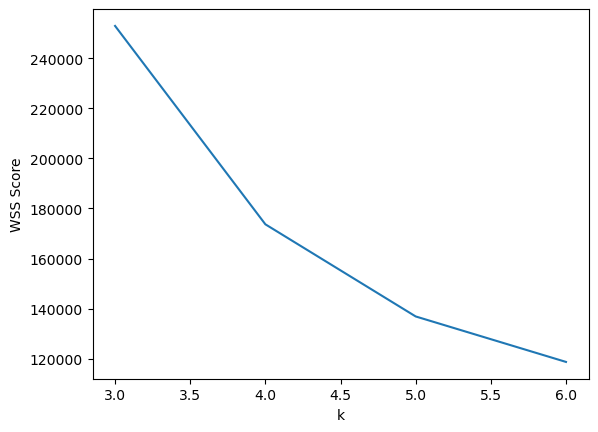

In [32]:
# Ahora se graficarán los WSS obtenidos para obtener lo que se conoce como diagrama de codo
plt.plot(num_clusters, score_wss)
plt.xlabel('k')
plt.ylabel('WSS Score')
plt.show()

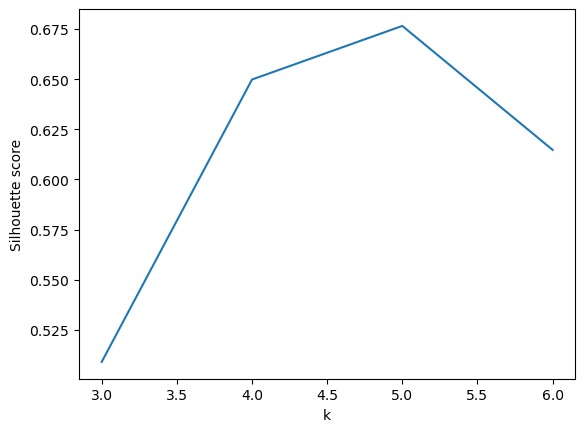

In [33]:
# Ahora se graficarán los silhouette scores obtenidos
plt.plot(num_clusters, score_sil)
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

In [34]:
# Seleccionamos como número de cluster óptimo al 5 y se vuelve a ejecutar el algoritmo k-means
kmeans = KMeans(featuresCol = 'explicativas_numericas_vector_escaladas', k = 5)
modelo = kmeans.fit(train)
clusters = modelo.transform(train)

In [35]:
# Finalmente, se obtienene los centroides de cada clúster
centros = modelo.clusterCenters()
print("Centros de los clústers: ")
for centro in centros:
    print(centro)

Centros de los clústers: 
[ 1.74888571  0.1292911  -0.09194889  0.13275135]
[ 0.62439778  0.04664255 12.39894453 11.14934415]
[-0.46600603 -0.31943738 -0.00591996 -0.07122497]
[ 1.45128700e+00 -8.99712893e-03  5.15497914e+01  6.35317018e+01]
[-0.02679333  2.00231316 -0.14072514 -0.0828983 ]
